# Resumes PDFs Text Analysis

In [1]:
import fitz
import pandas as pd
import numpy as np

## Reading Resumes PDF with PyMuPDF

In [2]:
cv_text_list = []
for i in range(1, 5036):
    try:
        doc = fitz.open(f"data/ResumesPDF/cv ({i}).pdf")
        page = doc[0]
        text = page.get_text()
        cv_text_list.append(text)
        doc.close()
    except Exception as e:
        print(e)

page 0 not in document
Cannot open empty file: filename='data/ResumesPDF/cv (1055).pdf'.
MuPDF error: format error: cmsOpenProfileFromMem failed

Failed to open file 'data/ResumesPDF/cv (2586).pdf'.
Failed to open file 'data/ResumesPDF/cv (3138).pdf'.
Failed to open file 'data/ResumesPDF/cv (3498).pdf'.
Failed to open file 'data/ResumesPDF/cv (4022).pdf'.


In [3]:
for text in cv_text_list[:10]:
    print(text)
    print('\n')
    print('==========================')

One97 Communications Limited 
Data Scientist Jan 2019 to Till Date 
Detect important information from images and redact
required fields. YOLO CNN Object-detection, OCR
Insights, find anomaly or performance drop in all
possible sub-space. 
Predict the Insurance claim probability. Estimate the
premium amount to be charged
B.Tech(Computer Science) from SGBAU university in
2017. 
M.Tech (Computer Science Engineering) from Indian
Institute of Technology (IIT), Kanpur in 2019
WORK EXPERIENCE
EDUCATION
MACY WILLIAMS
DATA SCIENTIST
Data Scientist working  on problems related to market research and customer analysis. I want to expand my arsenal of
application building and work on different kinds of problems. Looking for a role where I can work with a coordinative team
and exchange knowledge during the process.
Java, C++, Python, Machine Learning, Algorithms, Natural Language Processing, Deep Learning, Computer Vision, Pattern
Recognition, Data Science, Data Analysis, Software Engineer, Data Ana

## Reading Resumes PDF with pdfplumber

In [4]:
"""import pdfplumber

cv_text_list = []
for i in range(1, 5035):
    try:
        with pdfplumber.open(f'data/ResumesPDF/cv ({i}).pdf') as pdf:
            # Acessar a primeira página
            if pdf.pages:
                pagina = pdf.pages[0]

            # Extrair texto
            texto = pagina.extract_text()
            cv_text_list.append(texto)
    except Exception as e:
        print(e)"""

"import pdfplumber\n\ncv_text_list = []\nfor i in range(1, 5035):\n    try:\n        with pdfplumber.open(f'data/ResumesPDF/cv ({i}).pdf') as pdf:\n            # Acessar a primeira página\n            if pdf.pages:\n                pagina = pdf.pages[0]\n\n            # Extrair texto\n            texto = pagina.extract_text()\n            cv_text_list.append(texto)\n    except Exception as e:\n        print(e)"

In [5]:
"""for text in cv_text_list[:10]:
    print(text)
    print('\n')
    print('==========================')"""

"for text in cv_text_list[:10]:\n    print(text)\n    print('\n')\n    print('==========================')"

## Reading PDFs with PyPDF2

In [6]:
"""import PyPDF2

cv_text_list = []
for i in range(1, 5035):
    try:
        with open(f'data/ResumesPDF/cv ({i}).pdf', 'rb') as file:
            pdf = PyPDF2.PdfReader(file)
            if pdf.pages:
                pagina = pdf.pages[0]
            texto = pagina.extract_text()
            cv_text_list.append(texto)
    except Exception as e:
        print(e)"""

"import PyPDF2\n\ncv_text_list = []\nfor i in range(1, 5035):\n    try:\n        with open(f'data/ResumesPDF/cv ({i}).pdf', 'rb') as file:\n            pdf = PyPDF2.PdfReader(file)\n            if pdf.pages:\n                pagina = pdf.pages[0]\n            texto = pagina.extract_text()\n            cv_text_list.append(texto)\n    except Exception as e:\n        print(e)"

In [7]:
"""for text in cv_text_list[:10]:
    print(text)
    print('\n')
    print('==========================')"""

"for text in cv_text_list[:10]:\n    print(text)\n    print('\n')\n    print('==========================')"

## Configure Spark ENV Vars

In [8]:
import os
os.environ["PYSPARK_PYTHON"] = "C:/Users/Victor Dantas/PycharmProjects/EDA_Resumes/.venv/Scripts/python.exe"
os.environ["PYSPARK_DRIVER_PYTHON"] = "C:/Users/Victor Dantas/PycharmProjects/EDA_Resumes/.venv/Scripts/python.exe"

## Creating Spark Session

In [9]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("EDA Resumes").master("local[*]").config("spark.driver.memory", "6g").getOrCreate()
spark

In [10]:
resumes_data = spark.createDataFrame([(text, ) for text in cv_text_list], ['text_resume'])
resumes_data.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Data Pipeline

In [11]:
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import udf, col
import spacy
from pyspark.ml import Transformer

class TokenFilterChar(Transformer):
    def __init__(self, inputCol=None, outputCol=None):
        super(TokenFilterChar, self).__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, df):
        def remove_single_char_tokens(tokens):
            return [t for t in tokens if len(t) > 1]

        filter_udf = udf(remove_single_char_tokens, ArrayType(StringType()))
        return df.withColumn(self.outputCol, filter_udf(col(self.inputCol)))


class NerTransformer(Transformer):
    def __init__(self, inputCol=None, outputCol=None):
        super(NerTransformer, self).__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, df):
        nlp = spacy.load("en_core_web_trf")

        def extract_entities(text):
            if isinstance(text, list):
                text = " ".join(text)
            if not isinstance(text, str):
                return []
            doc = nlp(text)
            return [str(ent.text) for ent in doc.ents]

        ner_udf = udf(extract_entities, ArrayType(StringType()))
        return df.withColumn(self.outputCol, ner_udf(col(self.inputCol)))

In [12]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer

tokenizer  = RegexTokenizer(inputCol="text_resume", outputCol="words_resume", pattern="[\\s+|\\W]")
remover = StopWordsRemover(inputCol="words_resume", outputCol="words_filtered")
token_filter_char = TokenFilterChar(inputCol="words_filtered", outputCol="words_filtered")
ner_transformer = NerTransformer(inputCol="words_filtered", outputCol="words_ner")
vectorizer = CountVectorizer(inputCol=remover.getOutputCol(), outputCol="features_count")

pipeline = Pipeline(stages=[tokenizer, remover, token_filter_char, ner_transformer, vectorizer])

In [13]:
resumes_data.cache()
pipe = pipeline.fit(resumes_data)
resumes_data = pipe.transform(resumes_data)
resumes_data.show(truncate=False)

C:\Users\Victor Dantas\PycharmProjects\EDA_Resumes\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Tokens Frequency

In [14]:
pipe.stages

[RegexTokenizer_704581c97fd7,
 StopWordsRemover_a7a1df665582,
 TokenFilterChar_48ce3f5e8b47,
 NerTransformer_8bb220a67a49,
 CountVectorizerModel: uid=CountVectorizer_8c54ef595a22, vocabularySize=50588]

In [15]:
count_vec_model = pipe.stages[4]
vocab = count_vec_model.vocabulary

In [16]:
features = resumes_data.select("features_count").toPandas()["features_count"]
features_array = np.array([vec.toArray() for vec in features])

# Soma as frequências por coluna
freq_total = np.sum(features_array, axis=0)

In [17]:
import pandas as pd

freq_df = pd.DataFrame({
    "token": vocab,
    "frequency": freq_total
}).sort_values(by="frequency", ascending=False)

In [18]:
freq_df.head()

,token,frequency
0,experience,6784.0
1,work,5735.0
2,skills,5259.0
3,project,4965.0
4,company,4952.0


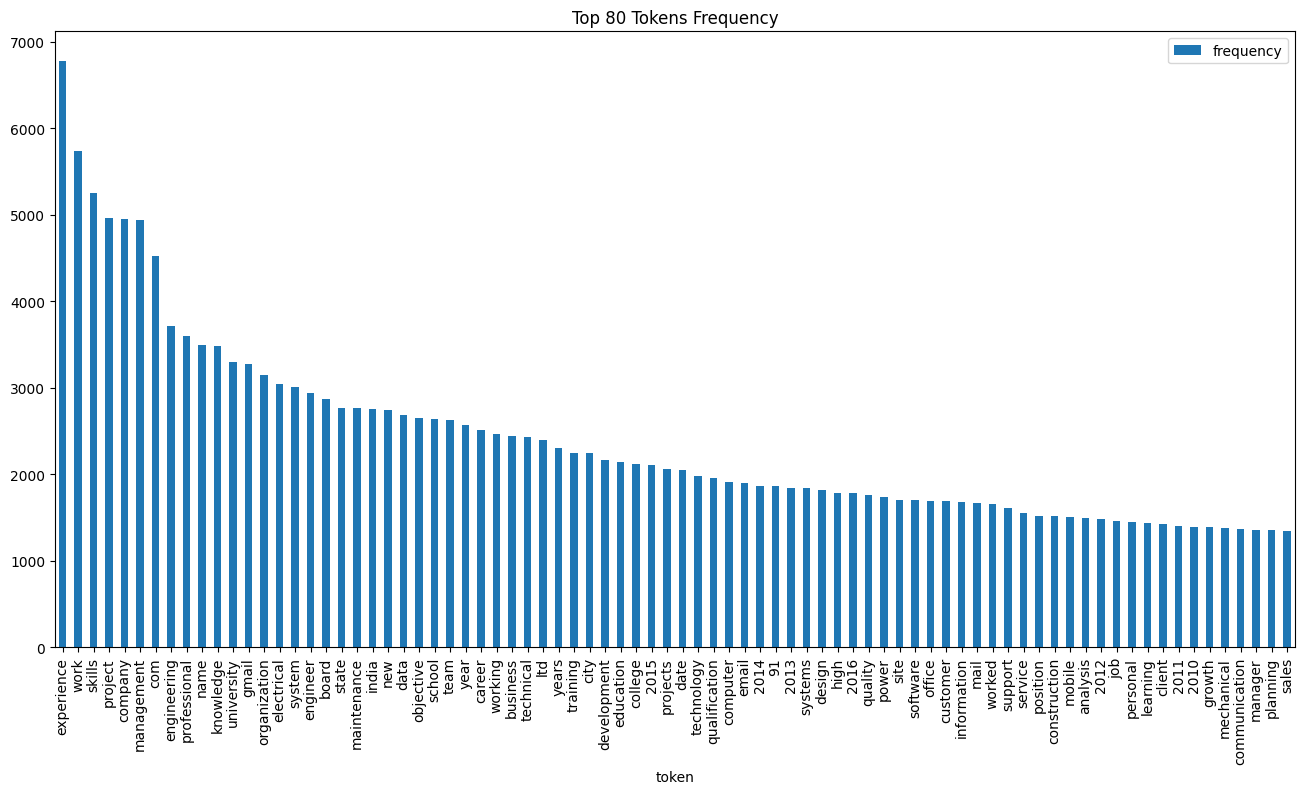

In [19]:
import matplotlib.pyplot as plt
top_k = 80
freq_df.iloc[:top_k].plot(kind="bar", x="token", y="frequency", figsize=(16, 8))
plt.xticks(rotation=90)
plt.title(f"Top {top_k} Tokens Frequency")
plt.show()

## Mean and Median Tokens By Document

In [20]:
freq_total_rows = np.sum(features_array, axis=1)
print(f'Mean of tokens by Document: {freq_total_rows.mean():.0f}')

Mean of tokens by Document: 186


In [21]:
freq_total_rows = np.sum(features_array, axis=1)
print(f'Median of tokens by Document: {np.median(freq_total_rows):.0f}')

Median of tokens by Document: 154


In [22]:
resumes_data.select('words_ner').show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|words_ner                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
+-------------------------------

## Applying Transformations to Jobs Description

In [23]:
job_descriptions = [
    {
        "title": "Backend Developer (Python/Django)",
        "location": "Remote",
        "description": (
            "We are seeking a highly skilled Python Developer with strong experience in Django and RESTful APIs. "
            "The ideal candidate has a deep understanding of relational databases (PostgreSQL), unit testing, and CI/CD pipelines. "
            "You will also be responsible for system architecture decisions and optimizing performance of data-intensive applications. "
            "Required skills: Python, Django, Django REST Framework, PostgreSQL, Redis, Celery, PyTest, Docker, Git, "
            "GitHub Actions or Jenkins, AWS (EC2, S3, Lambda), Linux CLI, Swagger/OpenAPI."
        )
    },
    {
        "title": "Frontend Developer (React/TypeScript)",
        "location": "San Francisco, CA (Hybrid)",
        "description": (
            "We are looking for a Frontend Engineer to build scalable and accessible web applications using React, Redux, and TypeScript. "
            "You'll collaborate with designers and backend engineers to deliver polished, user-centered products and reusable components. "
            "Required skills: React, Redux, TypeScript, Styled Components, Tailwind CSS, RESTful APIs, GraphQL, Jest, "
            "React Testing Library, Webpack, Vite, Accessibility standards (WCAG), Responsive design."
        )
    },
    {
        "title": "DevOps Engineer",
        "location": "Berlin, Germany (Remote possible)",
        "description": (
            "Join our infrastructure team to automate and scale our cloud-native platform. "
            "You'll build and maintain CI/CD pipelines, manage Kubernetes clusters, and enforce security best practices. "
            "Required skills: Docker, Kubernetes, Helm, Terraform, Ansible, AWS (EKS, IAM, CloudWatch), GCP, Bash, Python or Go, "
            "ArgoCD or Flux, Prometheus, Grafana, monitoring and logging systems."
        )
    },
    {
        "title": "Full Stack Developer (Node.js + Vue.js)",
        "location": "Toronto, ON (Remote)",
        "description": (
            "We’re hiring a Full Stack Developer to help build features end-to-end across our digital product. "
            "Backend logic with Node.js and Express, frontend components in Vue.js. "
            "Required skills: Node.js, Express.js, Vue.js 3, Vuex, Composition API, MongoDB, PostgreSQL, RESTful API design, "
            "Swagger/OpenAPI, WebSockets, JWT, OAuth2, Jest, Cypress, Docker."
        )
    },
    {
        "title": "Data Scientist",
        "location": "New York, NY",
        "description": (
            "Join our analytics team to extract insights from customer data, build machine learning models, and support data-driven decisions. "
            "You'll work with big data and real-time analytics systems. "
            "Required skills: Python (Pandas, NumPy, scikit-learn), SQL, BigQuery, Data visualization (Tableau, Matplotlib, Seaborn), "
            "A/B testing, Jupyter, Airflow, dbt, MLflow, Git."
        )
    },
    {
        "title": "Cloud Solutions Architect (AWS)",
        "location": "London, UK",
        "description": (
            "Design secure and scalable cloud architectures for enterprise-grade applications. "
            "Work closely with development teams and support cloud migrations. "
            "Required skills: AWS (EC2, S3, VPC, RDS, IAM, Lambda), Terraform, CloudFormation, Kubernetes, Docker, "
            "Cloud security best practices (CIS, ISO 27001), CI/CD automation, cost optimization, governance policies."
        )
    },
    {
        "title": "Cybersecurity Analyst",
        "location": "Remote (US only)",
        "description": (
            "Monitor network activity for threats, conduct vulnerability scans, and respond to incidents. "
            "Assist in policy creation and ensure compliance with industry standards. "
            "Required skills: SIEM tools (Splunk, QRadar, ELK), TCP/IP, HTTP, DNS, threat modeling, penetration testing, "
            "Nessus, Qualys, firewalls, antivirus, knowledge of SOC 2, HIPAA, or NIST frameworks."
        )
    },
    {
        "title": "Machine Learning Engineer",
        "location": "Remote",
        "description": (
            "Design and deploy ML models in production systems. "
            "Collaborate with data engineers and product teams for end-to-end implementation. "
            "Required skills: Python, PyTorch, TensorFlow, HuggingFace, MLflow, SageMaker, Kubeflow, Apache Kafka, Airflow, "
            "ROC/AUC, Optuna, Hyperopt, Docker, Kubernetes."
        )
    },
    {
        "title": "Mobile Developer (Flutter)",
        "location": "São Paulo, Brazil (Hybrid)",
        "description": (
            "We are looking for a Mobile Developer to build modern cross-platform applications using Flutter. "
            "You'll participate in full app lifecycle from prototype to deployment. "
            "Required skills: Dart, Flutter SDK, Firebase (Auth, Firestore, Crashlytics), RESTful APIs, GraphQL, Fastlane, Codemagic, "
            "Android/iOS deployment, BLoC pattern, Clean architecture."
        )
    },
    {
        "title": "QA Automation Engineer",
        "location": "Austin, TX",
        "description": (
            "Develop and maintain end-to-end automated test suites. "
            "Collaborate with developers to define test strategies and ensure software quality across web and API layers. "
            "Required skills: Selenium, Cypress, Playwright, Postman, RestAssured, Python or Java, Jenkins, GitLab CI/CD, "
            "Test case management, Jira, JMeter or k6."
        )
    }
]


In [24]:
jobs_df = spark.createDataFrame(job_descriptions, ['description', 'location', 'title'])
jobs_df.toPandas()

,description,location,title
0,We are seeking a highly skilled Python Develop...,Remote,Backend Developer (Python/Django)
1,We are looking for a Frontend Engineer to buil...,"San Francisco, CA (Hybrid)",Frontend Developer (React/TypeScript)
2,Join our infrastructure team to automate and s...,"Berlin, Germany (Remote possible)",DevOps Engineer
3,We’re hiring a Full Stack Developer to help bu...,"Toronto, ON (Remote)",Full Stack Developer (Node.js + Vue.js)
4,Join our analytics team to extract insights fr...,"New York, NY",Data Scientist
5,Design secure and scalable cloud architectures...,"London, UK",Cloud Solutions Architect (AWS)
6,"Monitor network activity for threats, conduct ...",Remote (US only),Cybersecurity Analyst
7,Design and deploy ML models in production syst...,Remote,Machine Learning Engineer
8,We are looking for a Mobile Developer to build...,"São Paulo, Brazil (Hybrid)",Mobile Developer (Flutter)
9,Develop and maintain end-to-end automated test...,"Austin, TX",QA Automation Engineer


In [25]:
from pyspark.sql.functions import concat_ws
jobs_df = jobs_df.withColumn('document', concat_ws(" ", col('title'), col('description'), col('location')))
jobs_df.toPandas()

,description,location,title,document
0,We are seeking a highly skilled Python Develop...,Remote,Backend Developer (Python/Django),Backend Developer (Python/Django) We are seeki...
1,We are looking for a Frontend Engineer to buil...,"San Francisco, CA (Hybrid)",Frontend Developer (React/TypeScript),Frontend Developer (React/TypeScript) We are l...
2,Join our infrastructure team to automate and s...,"Berlin, Germany (Remote possible)",DevOps Engineer,DevOps Engineer Join our infrastructure team t...
3,We’re hiring a Full Stack Developer to help bu...,"Toronto, ON (Remote)",Full Stack Developer (Node.js + Vue.js),Full Stack Developer (Node.js + Vue.js) We’re ...
4,Join our analytics team to extract insights fr...,"New York, NY",Data Scientist,Data Scientist Join our analytics team to extr...
5,Design secure and scalable cloud architectures...,"London, UK",Cloud Solutions Architect (AWS),Cloud Solutions Architect (AWS) Design secure ...
6,"Monitor network activity for threats, conduct ...",Remote (US only),Cybersecurity Analyst,Cybersecurity Analyst Monitor network activity...
7,Design and deploy ML models in production syst...,Remote,Machine Learning Engineer,Machine Learning Engineer Design and deploy ML...
8,We are looking for a Mobile Developer to build...,"São Paulo, Brazil (Hybrid)",Mobile Developer (Flutter),Mobile Developer (Flutter) We are looking for ...
9,Develop and maintain end-to-end automated test...,"Austin, TX",QA Automation Engineer,QA Automation Engineer Develop and maintain en...


In [26]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer

tokenizer  = RegexTokenizer(inputCol="document", outputCol="words_job", pattern="[\\s+|\\W]")
remover = StopWordsRemover(inputCol="words_job", outputCol="words_filtered")
token_filter_char = TokenFilterChar(inputCol="words_filtered", outputCol="words_filtered")
ner_transformer = NerTransformer(inputCol="words_filtered", outputCol="words_ner")
vectorizer = CountVectorizer(inputCol=remover.getOutputCol(), outputCol="features_count")

pipeline = Pipeline(stages=[tokenizer, remover, token_filter_char, ner_transformer, vectorizer])

In [27]:
jobs_df.cache()
pipe = pipeline.fit(jobs_df)
jobs_df = pipe.transform(jobs_df)

jobs_df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|         description|            location|               title|            document|        words_resume|      words_filtered|           words_ner|      features_count|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|We are seeking a ...|              Remote|Backend Developer...|Backend Developer...|[backend, develop...|[backend, develop...|[python, django, ...|(309,[0,1,3,4,5,8...|
|We are looking fo...|San Francisco, CA...|Frontend Develope...|Frontend Develope...|[frontend, develo...|[frontend, develo...|[react, react red...|(309,[0,1,5,7,11,...|
|Join our infrastr...|Berlin, Germany (...|     DevOps Engineer|DevOps Engineer J...|[devops, engineer...|[devops, engineer...|[kubernetes clust...|(3

In [28]:
jobs_df.show(truncate=False)

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "C:\Users\Victor Dantas\PycharmProjects\EDA_Resumes\.venv\lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "C:\Users\Victor Dantas\PycharmProjects\EDA_Resumes\.venv\lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "C:\Users\Victor Dantas\AppData\Local\Programs\Python\Python310\lib\socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

## Using LLMs to generate Embeddings

In [29]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

C:\Users\Victor Dantas\PycharmProjects\EDA_Resumes\.venv\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Victor Dantas\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is

In [33]:
embeddings = model.encode(list(jobs_df.select('title')))
embeddings

array([[ 4.14334647e-02,  7.99367502e-02, -5.05866595e-02,
         3.92575264e-02, -1.95751414e-02,  2.18726955e-02,
         1.41208642e-03,  3.36655974e-02,  5.93213597e-03,
         9.76763899e-04, -3.19274180e-02, -2.03170590e-02,
         3.61247025e-02, -1.06053554e-01, -5.12769111e-02,
        -1.19538130e-02, -5.22282645e-02, -1.41365211e-02,
         5.49268313e-02,  8.86531454e-03, -9.77838971e-03,
         4.72688563e-02, -3.48673165e-02,  4.90482897e-02,
         2.91124056e-03,  6.09793663e-02, -1.79398023e-02,
         1.15136504e-01, -1.73971951e-02, -3.96927111e-02,
        -3.42040025e-02, -4.65826392e-02,  2.18242537e-02,
         4.66166735e-02,  2.18693502e-02, -3.93004641e-02,
        -1.30173238e-03,  3.47399749e-02,  6.53659105e-02,
         3.51685621e-02,  7.74865523e-02, -1.34413213e-01,
         3.08153499e-02, -6.43473640e-02, -7.86393322e-03,
        -7.11153224e-02,  2.15897476e-03, -1.08331658e-01,
         1.80542171e-02, -1.51331052e-02,  9.77918692e-0